In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [49]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [28]:
def plot_key(df, key):
    if (key.endswith(('bin', 'cat')) or len(df[key].value_counts()) < 16):
        df0 = df[[key, 'target']].copy()
    else :
        df0 = df[[key, 'target']].copy()
        bins = np.unique(df0[key].quantile(np.arange(17)/16.).values)
        bins[0] -= 0.00001
        df0.loc[:, key] = pd.cut(df0[key], bins, labels=np.arange(len(bins)-1))
    mean = df0[[key, 'target']].groupby(key, as_index=False).mean()
    mean = mean.rename(columns={'target':'mean'})
    count = df0[[key, 'target']].groupby(key, as_index=False).count()
    count = count.rename(columns={'target':'n'})
    std = df0[[key, 'target']].groupby(key).std().reset_index()
    std = std.rename(columns={'target':'std'})
    tmp = mean.merge(count, on = key)
    tmp = tmp.merge(std, on = key)
    tmp.loc[:, 'se'] = tmp['std'] / np.sqrt(tmp.n * 1.)
    tmp.loc[:, '-3ses'] = tmp['mean'] - 3 * tmp['se']
    tmp.loc[:, '+3ses'] = tmp['mean'] + 3 * tmp['se']
    num_bins = tmp.shape[0]
    df0[key].hist(bins=num_bins*2)
    plt.show()
    fig = tmp.plot(x=key, y=['-3ses', 'mean', '+3ses'], style='-o')
    plt.show()

In [20]:
def handle_group_keys(group):
    for key in group:
        plot_key(train, key)

In [29]:
ind_feas = [c for c in train.columns if c.startswith('ps_ind')]
reg_feas = [c for c in train.columns if c.startswith('ps_reg')]
car_feas = [c for c in train.columns if c.startswith('ps_car')]
calc_feas = [c for c in train.columns if c.startswith('ps_calc')]

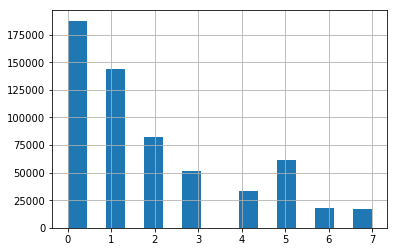

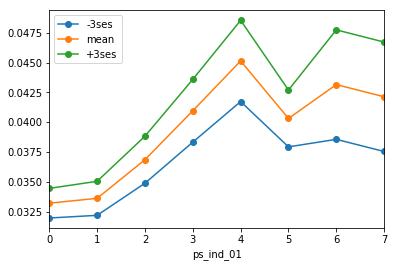

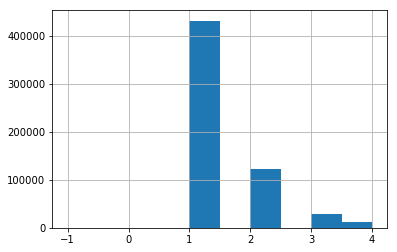

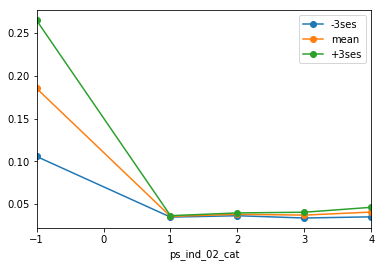

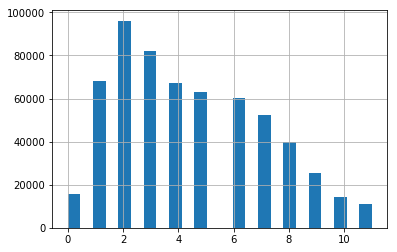

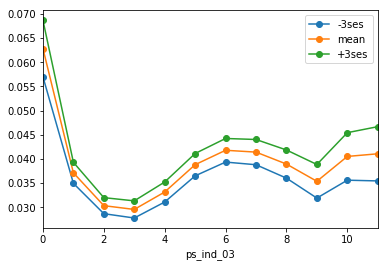

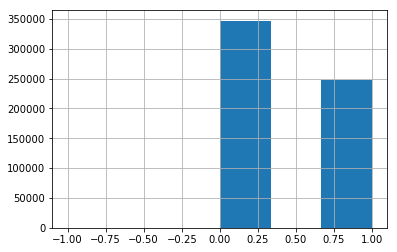

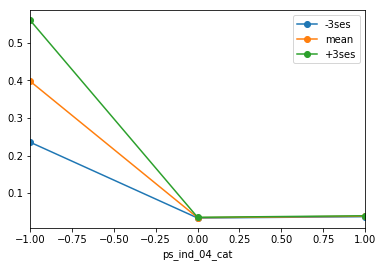

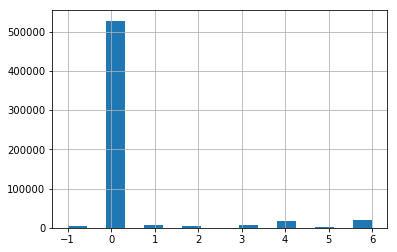

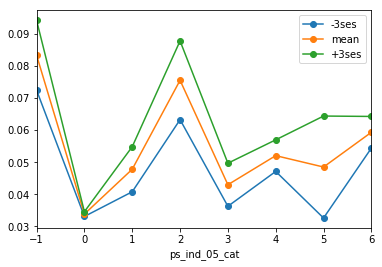

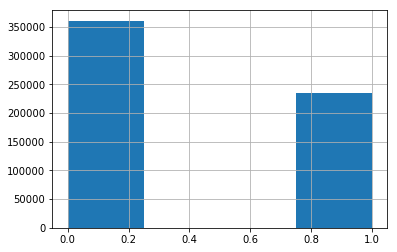

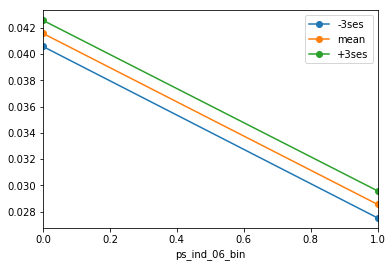

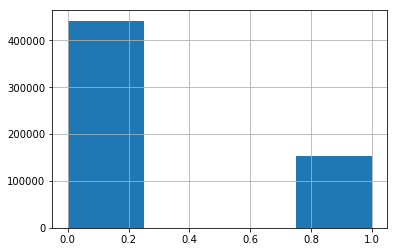

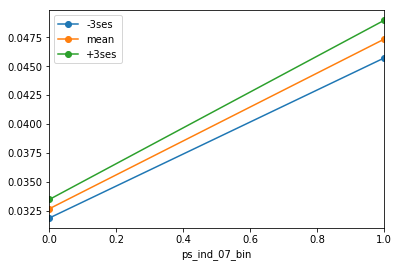

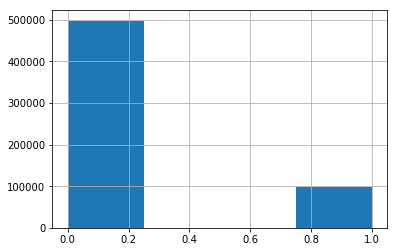

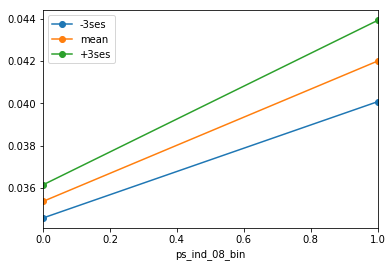

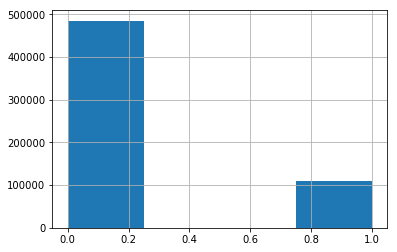

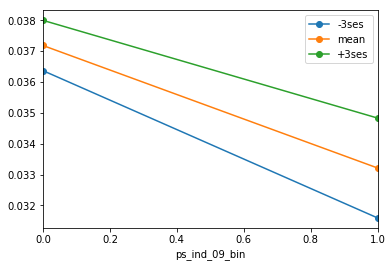

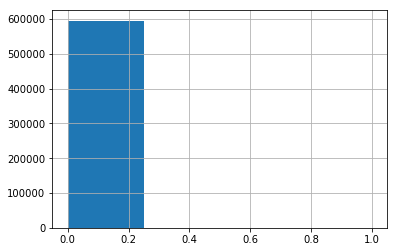

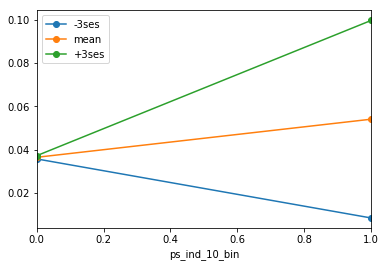

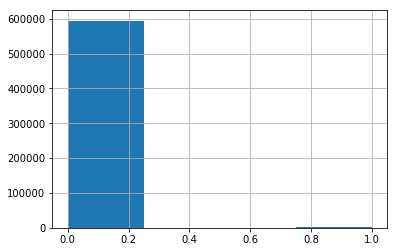

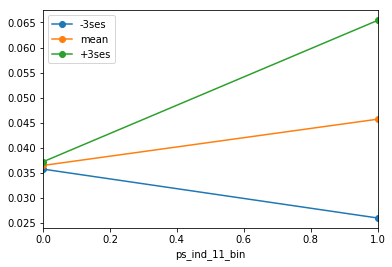

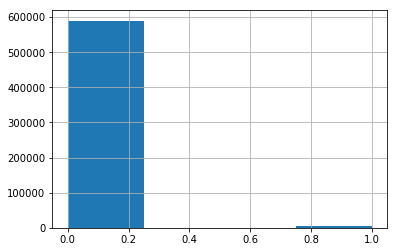

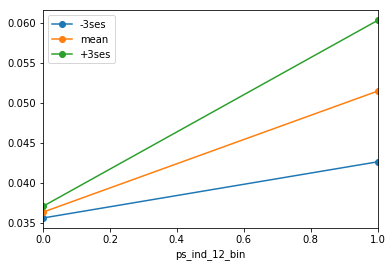

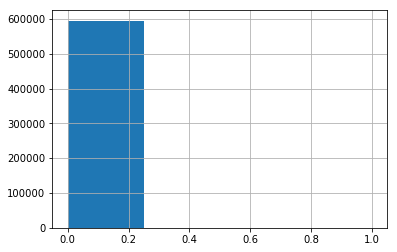

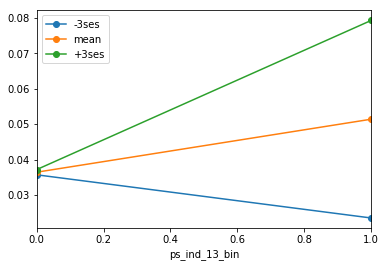

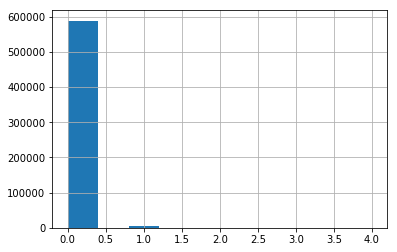

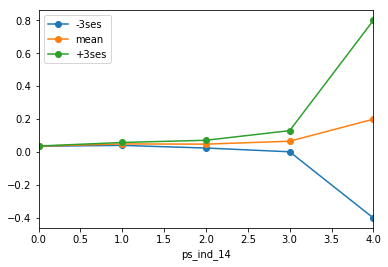

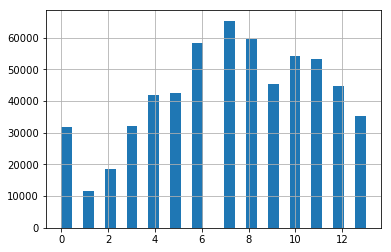

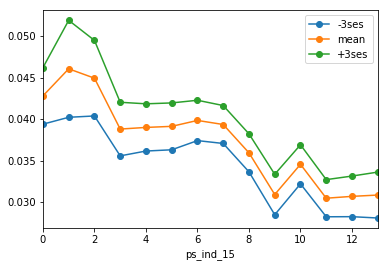

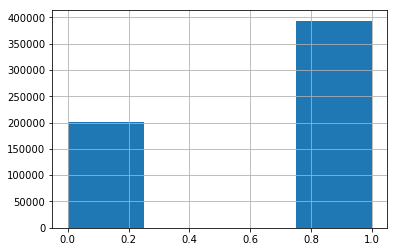

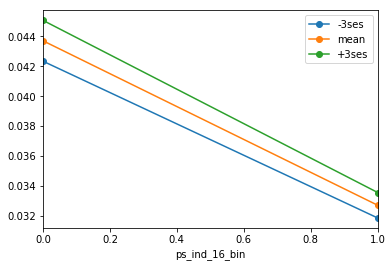

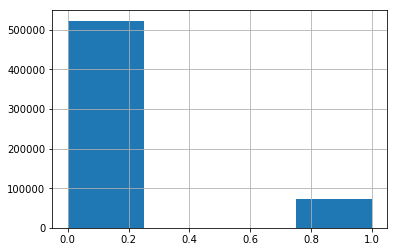

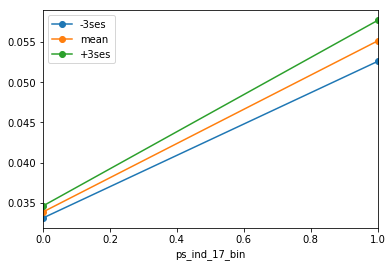

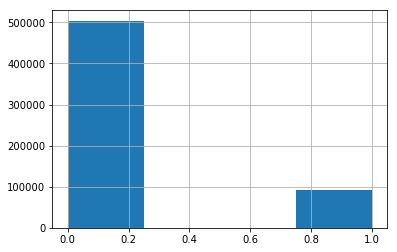

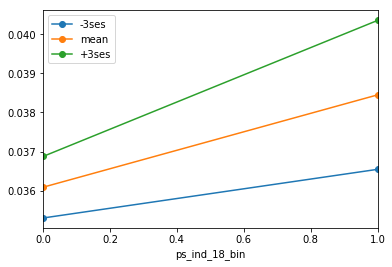

In [22]:
handle_group_keys(ind_feas)

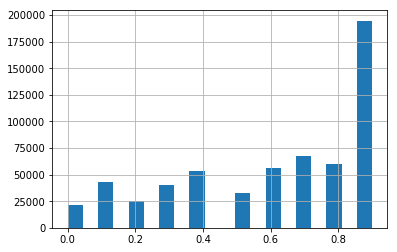

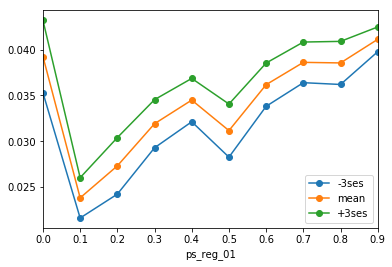

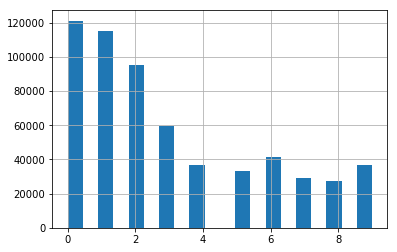

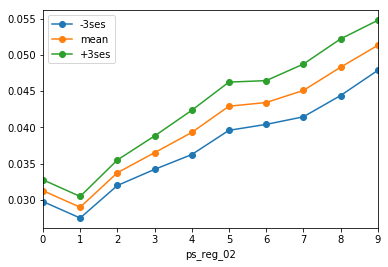

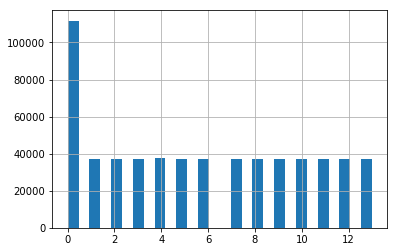

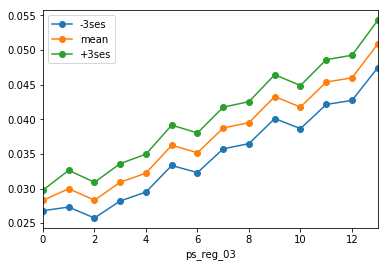

In [23]:
handle_group_keys(reg_feas)

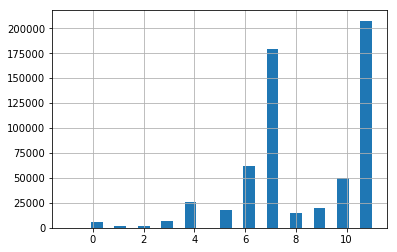

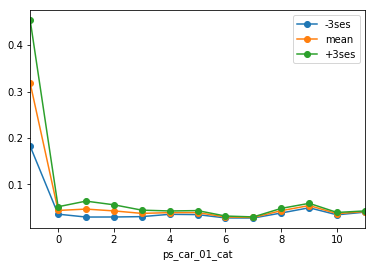

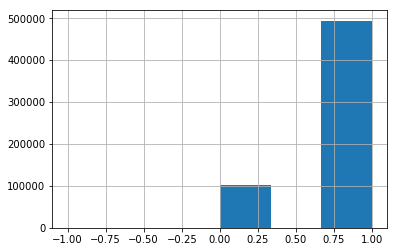

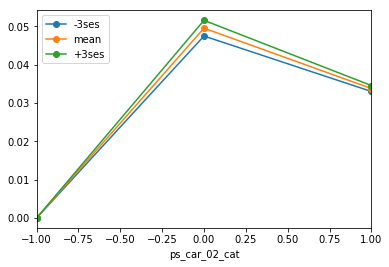

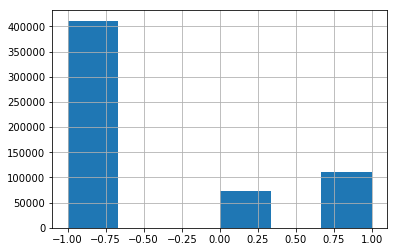

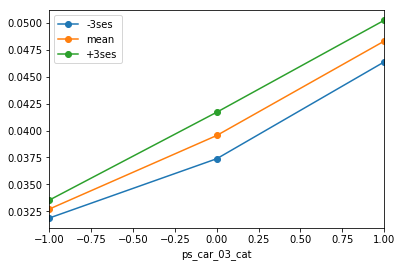

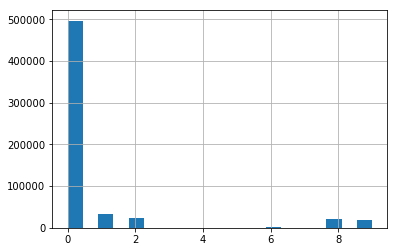

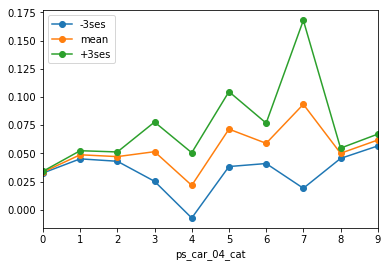

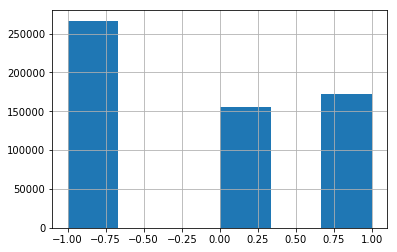

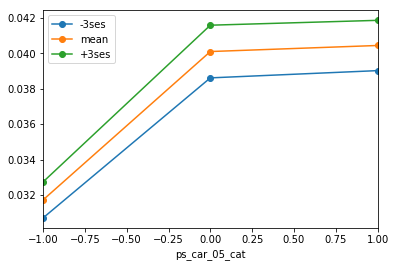

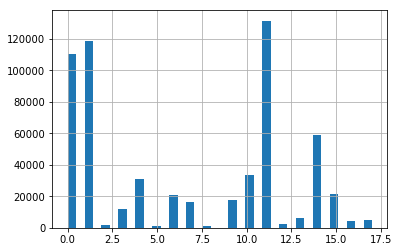

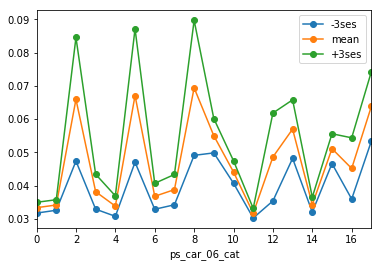

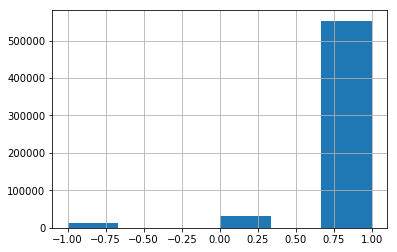

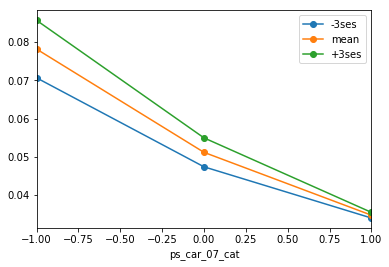

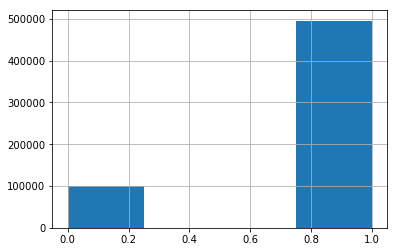

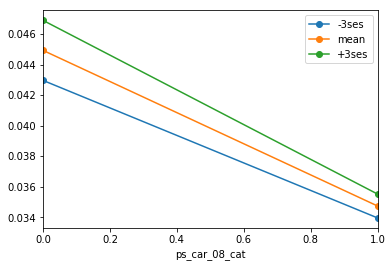

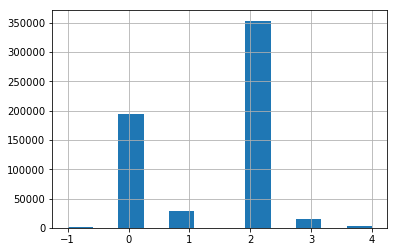

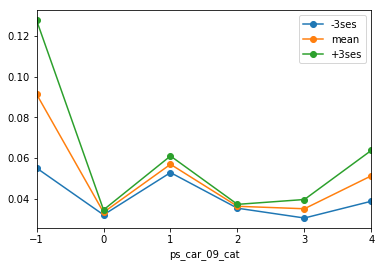

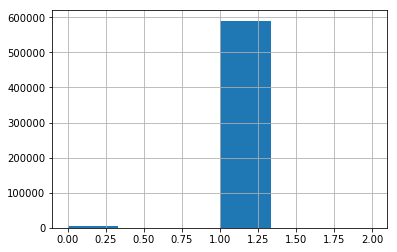

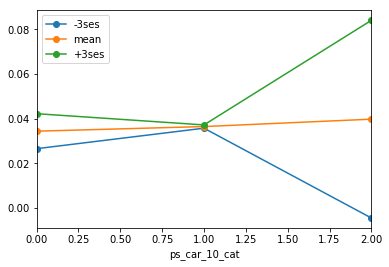

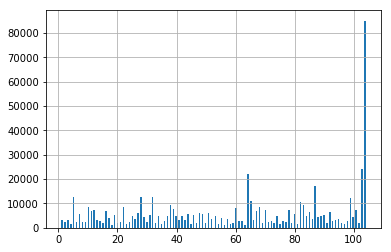

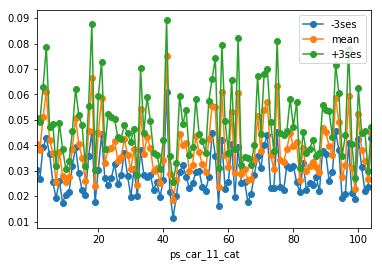

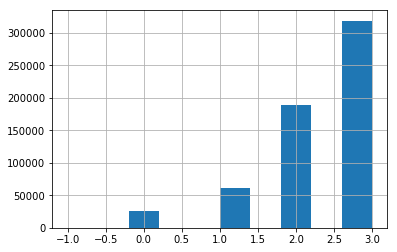

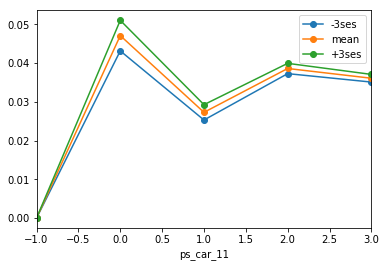

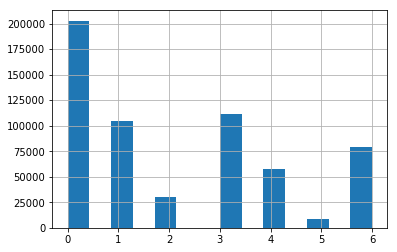

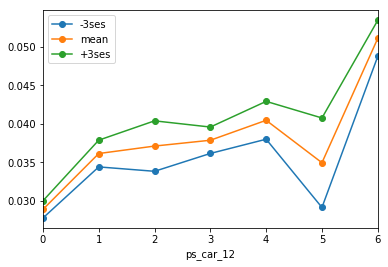

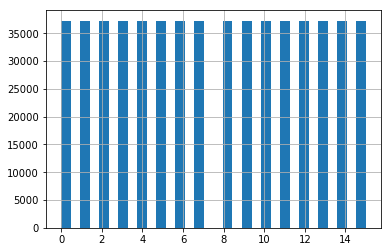

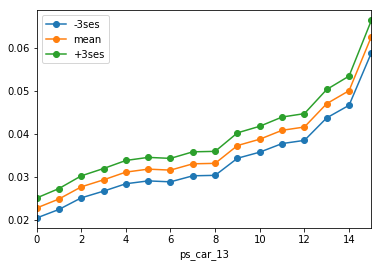

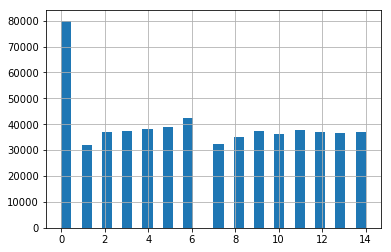

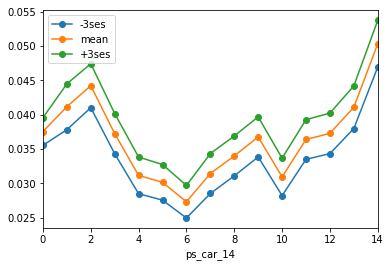

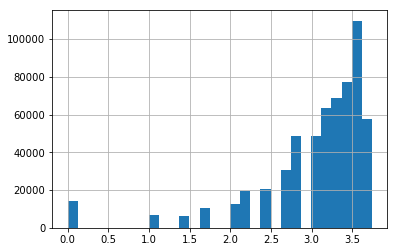

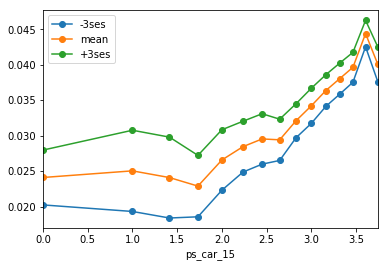

In [30]:
handle_group_keys(car_feas)

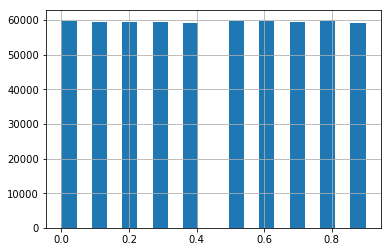

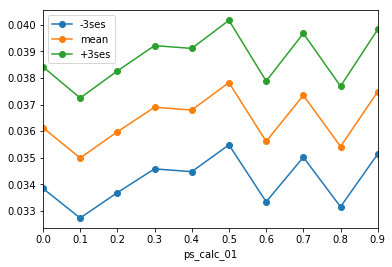

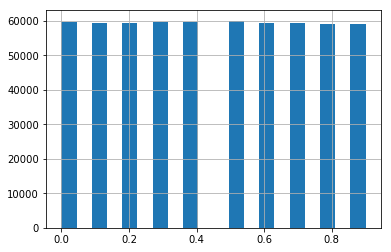

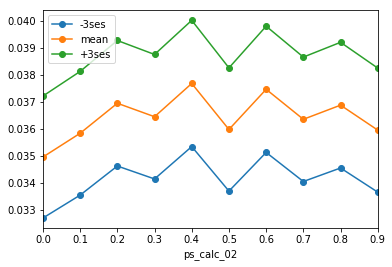

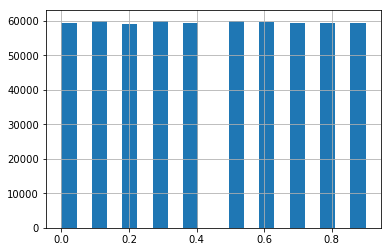

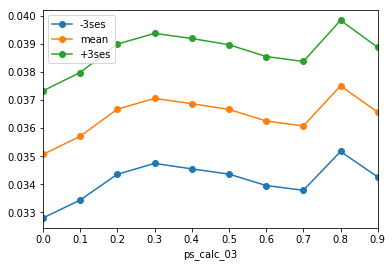

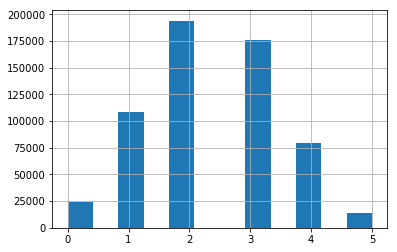

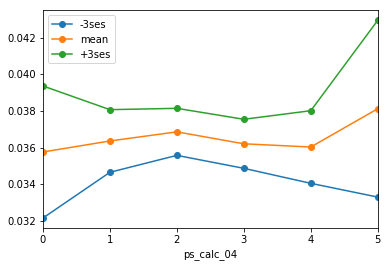

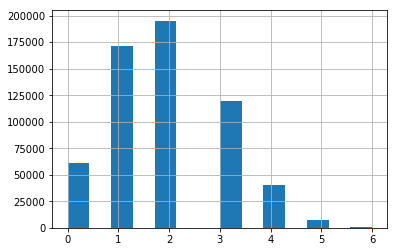

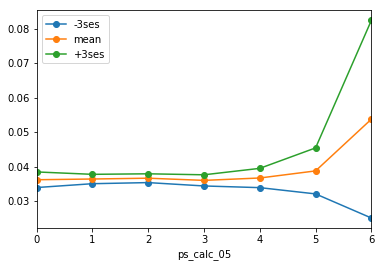

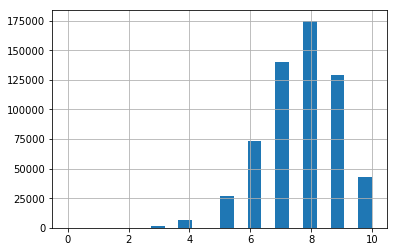

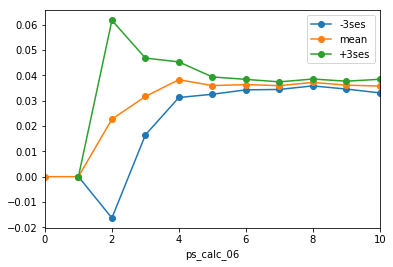

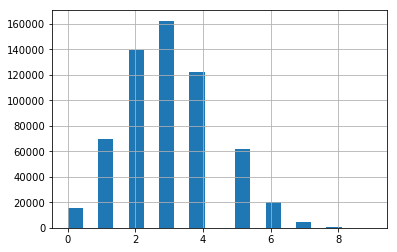

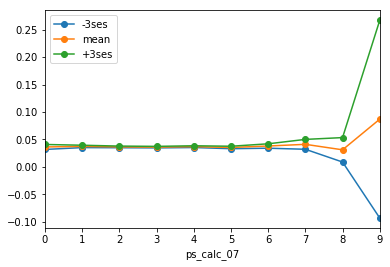

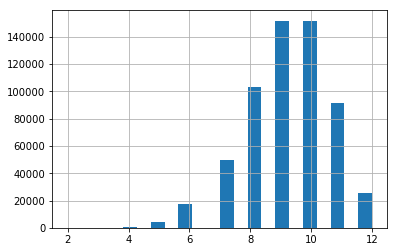

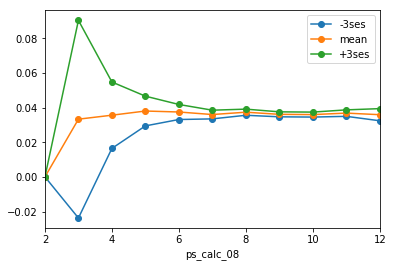

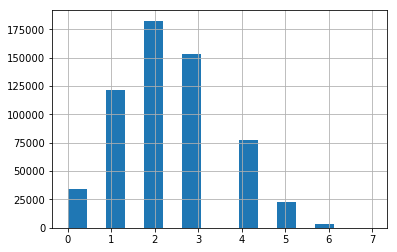

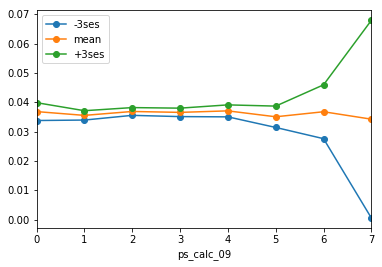

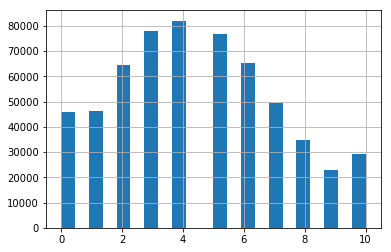

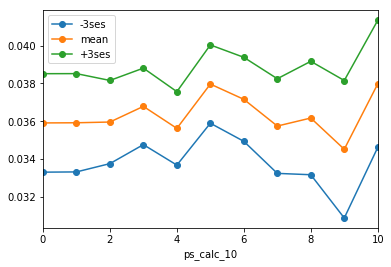

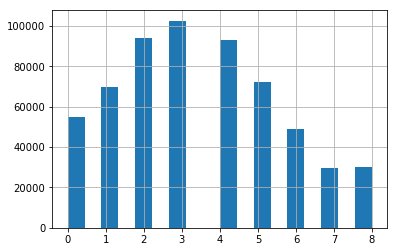

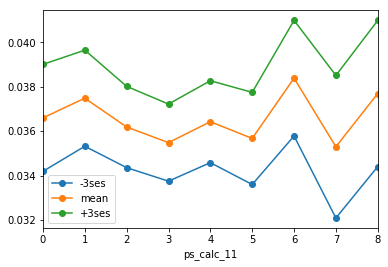

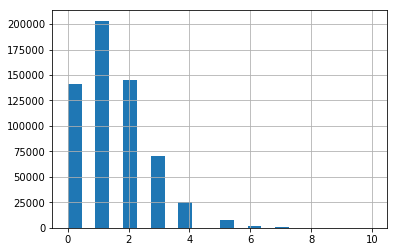

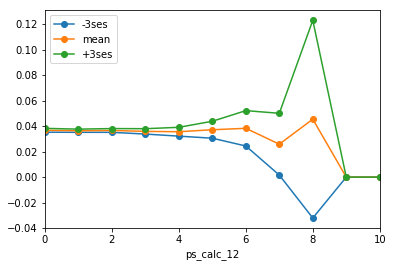

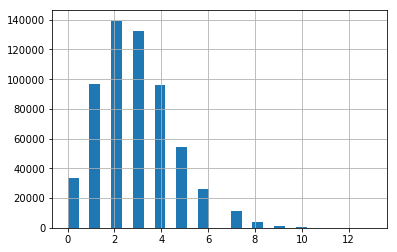

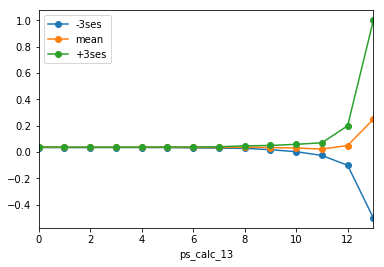

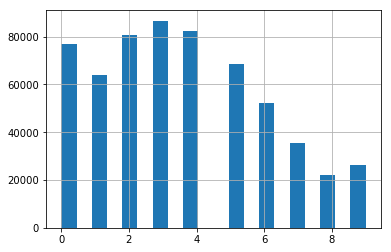

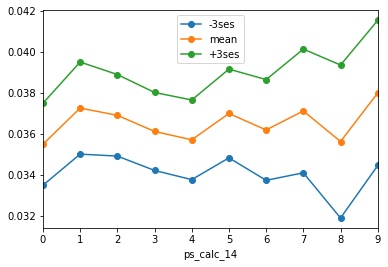

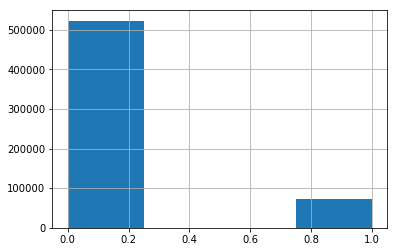

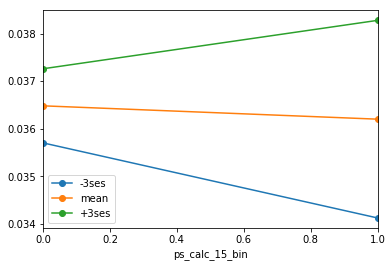

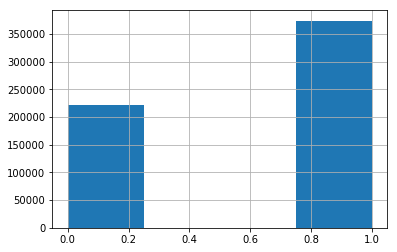

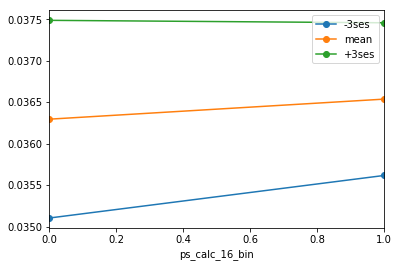

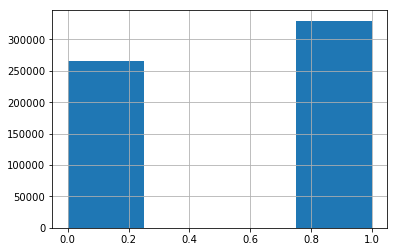

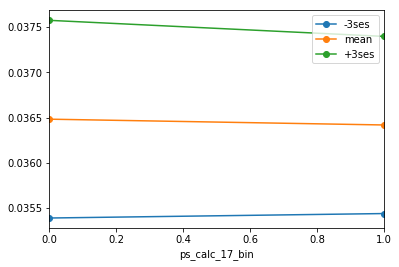

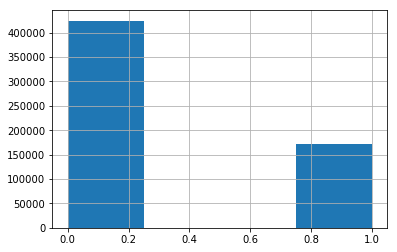

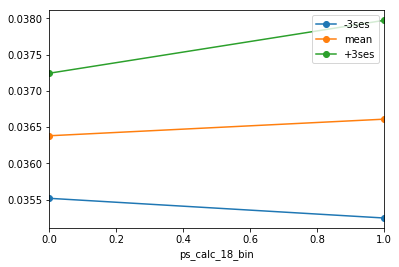

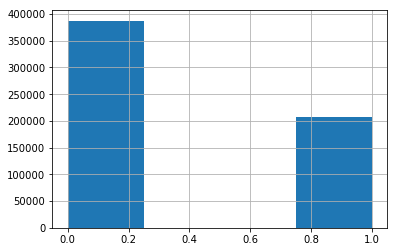

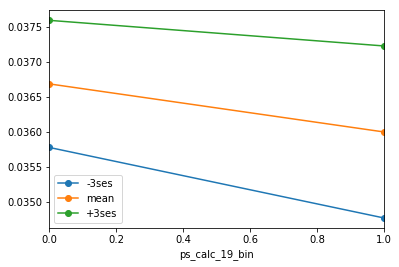

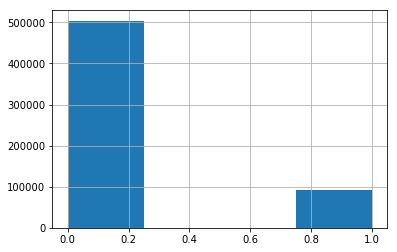

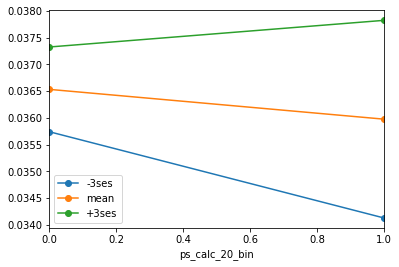

In [25]:
handle_group_keys(calc_feas)

In [52]:
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import pandas as pd
import numpy as np

/Users/jingfeijia/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [56]:
# Read in our input data
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')


# This prints out (rows, columns) in each dataframe
print('Train shape:', df_train.shape)
print('Test shape:', df_test.shape)

print('Columns:', df_train.columns)

y_train = df_train['target'].values
id_train = df_train['id'].values
id_test = df_test['id'].values

# We drop these variables as we don't want to train on them
# The other 57 columns are all numerical and can be trained on without preprocessing
x_train = df_train.drop(['target', 'id'], axis=1)
x_test = df_test.drop(['id'], axis=1)

# Take a random 20% of the dataset as validation data
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)
print('Train samples: {} Validation samples: {}'.format(len(x_train), len(x_valid)))

# Convert our data into XGBoost format
d_train = xgb.DMatrix(x_train, y_train)
d_valid = xgb.DMatrix(x_valid, y_valid)
d_test = xgb.DMatrix(x_test)

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.05
params['silent'] = True
params['max_depth'] = 5
params['subsample'] = 0.8
params['colsample_bytree'] = 0.8

# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

# Create an XGBoost-compatible metric from Gini

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return [('gini', gini_score)]

# This is the data xgboost will test on after eachboosting round
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

# Train the model! We pass in a max of 10,000 rounds (with early stopping after 100)
# and the custom metric (maximize=True tells xgb that higher metric is better)
mdl = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, feval=gini_xgb, maximize=True, verbose_eval=10)

# Predict on our test data
p_test = mdl.predict(d_test)

# Create a submission file
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = p_test
sub.to_csv('xgb1.csv', index=False)

print(sub.head())

('Train shape:', (595212, 59))
('Test shape:', (892816, 58))
('Columns:', Index([u'id', u'target', u'ps_ind_01', u'ps_ind_02_cat', u'ps_ind_03',
       u'ps_ind_04_cat', u'ps_ind_05_cat', u'ps_ind_06_bin', u'ps_ind_07_bin',
       u'ps_ind_08_bin', u'ps_ind_09_bin', u'ps_ind_10_bin', u'ps_ind_11_bin',
       u'ps_ind_12_bin', u'ps_ind_13_bin', u'ps_ind_14', u'ps_ind_15',
       u'ps_ind_16_bin', u'ps_ind_17_bin', u'ps_ind_18_bin', u'ps_reg_01',
       u'ps_reg_02', u'ps_reg_03', u'ps_car_01_cat', u'ps_car_02_cat',
       u'ps_car_03_cat', u'ps_car_04_cat', u'ps_car_05_cat', u'ps_car_06_cat',
       u'ps_car_07_cat', u'ps_car_08_cat', u'ps_car_09_cat', u'ps_car_10_cat',
       u'ps_car_11_cat', u'ps_car_11', u'ps_car_12', u'ps_car_13',
       u'ps_car_14', u'ps_car_15', u'ps_calc_01', u'ps_calc_02', u'ps_calc_03',
       u'ps_calc_04', u'ps_calc_05', u'ps_calc_06', u'ps_calc_07',
       u'ps_calc_08', u'ps_calc_09', u'ps_calc_10', u'ps_calc_11',
       u'ps_calc_12', u'ps_calc_13', u'ps

In [ ]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

# fit model no training data
model = XGBClassifier(n_jobs=8)
model.fit(x_train, y_train)
# plot feature importance
fig, ax = plt.subplots(figsize = (20, 10))
plot_importance(model, ax=ax)
pyplot.show()

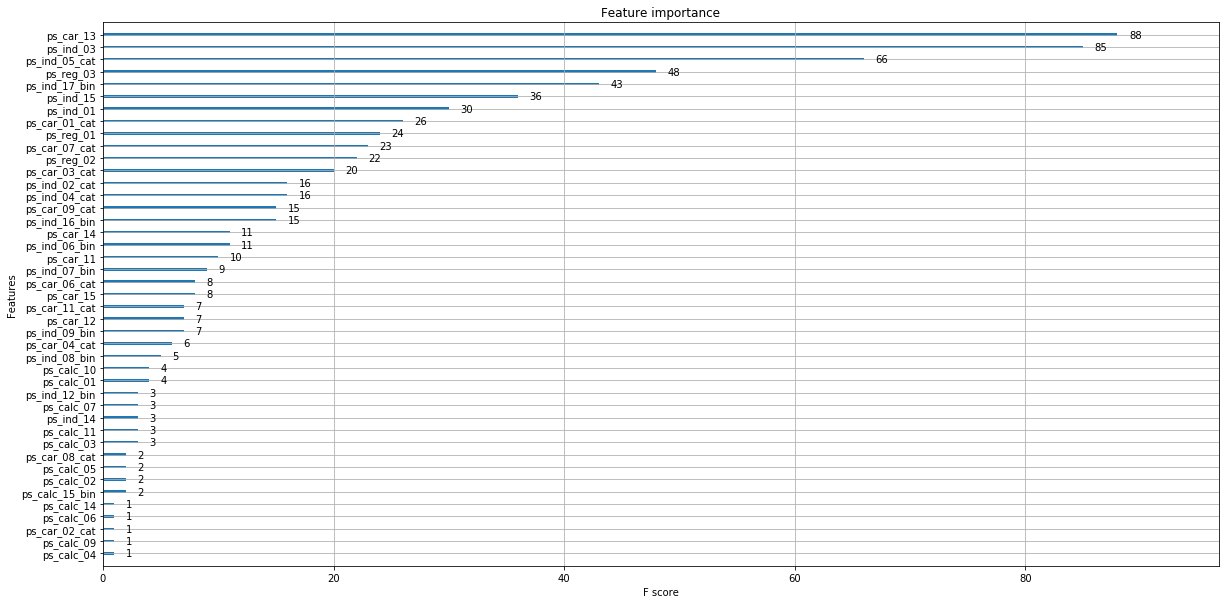

In [70]:
fig, ax = plt.subplots(figsize = (20, 10))
plot_importance(model, ax=ax)
pyplot.show()

In [64]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


import keras
import sklearn.model_selection
import numpy as np
import pandas as pd


# Load Datasets
df_train  = pd.read_csv('../data/train.csv')
df_test   = pd.read_csv('../data/test.csv')
df_submit = pd.read_csv('../data/sample_submission.csv')

# To numpy array - dataset of train
x_all = df_train.drop(['target', 'id'], axis=1).values
y_all = keras.utils.np_utils.to_categorical(df_train['target'].values)

# For imbalanced data, better-way maybe exist!
# Please tell me better way by comment! Thanks!!
y_all_0 = y_all[y_all[:,1]==0]
y_all_1 = y_all[y_all[:,1]==1]
x_all   = np.concatenate([x_all[y_all[:,1]==0], np.repeat(x_all[y_all[:,1]==1], repeats=int(len(y_all_0)/len(y_all_1)), axis=0)], axis=0)
y_all   = np.concatenate([y_all[y_all[:,1]==0], np.repeat(y_all[y_all[:,1]==1], repeats=int(len(y_all_0)/len(y_all_1)), axis=0)], axis=0)

# Split train/valid datasets
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(x_all, y_all, test_size=0.3, random_state=0)

# Define model
model = keras.models.Sequential()
model.add(keras.layers.normalization.BatchNormalization(input_shape=tuple([x_train.shape[1]])))
model.add(keras.layers.core.Dense(32, activation='relu'))
model.add(keras.layers.core.Dropout(rate=0.5))
model.add(keras.layers.normalization.BatchNormalization())
model.add(keras.layers.core.Dense(32, activation='relu'))
model.add(keras.layers.core.Dropout(rate=0.5))
model.add(keras.layers.normalization.BatchNormalization())
model.add(keras.layers.core.Dense(32, activation='relu'))
model.add(keras.layers.core.Dropout(rate=0.5))
model.add(keras.layers.core.Dense(2, activation='sigmoid'))
model.compile(loss="categorical_crossentropy", optimizer="adadelta",metrics=["accuracy"])
print(model.summary())

# Use Early-Stopping
callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')

# Train model
model.fit(x_train, y_train, batch_size=1024, epochs=200, validation_data=(x_valid, y_valid), verbose=1, callbacks=[callback_early_stopping])

# Predict test dataset
x_test = df_test.drop(['id'], axis=1).values
y_test = model.predict(x_test)

# Output
df_submit['target'] = y_test[:, 1]
df_submit.to_csv('submission_output.csv', index=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 57)                228       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1856      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
__________